# From rate to discrete events
Our objective is to convert a rate (of number of vehicles, speed, weight) and convert into discrete events

## Setup
### Useful imports

In [1]:
import os
import datetime
import pickle
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import statsmodels.api as sm
import statsmodels.formula.api as smf
from collections import Counter

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from utils import *
%load_ext autoreload
%autoreload 2

### Load data

In [2]:
DATA_PATH = '../data/405.txt'
OUTPUT_PATH = '../data/predictions.csv'

cols_map = {
    "DTS": "crossTime",
    "SPEED": "speed",
    "GW_TOT": "weight",
}

data = pd.read_csv(DATA_PATH, usecols=cols_map.keys())
data.rename(columns=cols_map, inplace=True)
# Parse crossTime column as datetime object
data.crossTime = pd.to_datetime(data.crossTime+'0000', format='%Y-%m-%d %H:%M:%S.%f')
# Drop duplicate rows
data = data.drop_duplicates()
data.head(2)

,crossTime,speed,weight
0,2011-04-01 00:41:31.400,106,15980
1,2011-04-01 00:42:10.500,116,3630


### Truncate data
In our data exploration we observed that we have missing datapoints towards the start of the COVID pandemic so we decide to omit this time period.

In [3]:
# Truncate data to ignore COVID pandemic 
start_of_covid = "2019-10-21"
data = data.set_index('crossTime')         \
           .sort_index()                   \
           .truncate(after=start_of_covid) \
           .reset_index()

### Adding attributes
We will add useful attributes to facilitate our data exploration:
- Time of the day
- Day of the week
- Month of the year

In [4]:
data['hour'] = data.crossTime.map(lambda t: t.hour)
data['minute'] = data.crossTime.map(lambda t: t.minute)

In [5]:
data['weekday'] = data.crossTime.map(lambda t: t.weekday())

# Weekday ID -> weekday string representation
weekday_dict = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

In [6]:
data['month'] = data.crossTime.map(lambda t: t.month)
data['year'] = data.crossTime.map(lambda t: t.year)

In [7]:
data.sample(4)

,crossTime,speed,weight,hour,minute,weekday,month,year
693975,2012-06-15 10:02:19.400,84,21420,10,2,4,6,2012
2777556,2017-07-31 10:01:40.000,84,30140,10,1,0,7,2017
2758130,2017-07-19 12:04:30.600,80,21550,12,4,2,7,2017
2651835,2017-05-22 13:49:02.900,71,3760,13,49,0,5,2017


## Data exploration
Before going any further, we would like to know more about specific trends and structure in the data to help us perform the discretisation.

### Number of vehicles
We are interested in how the number of vehicles evolve over time, to see if there is a difference between days of the week and/or months of the year.

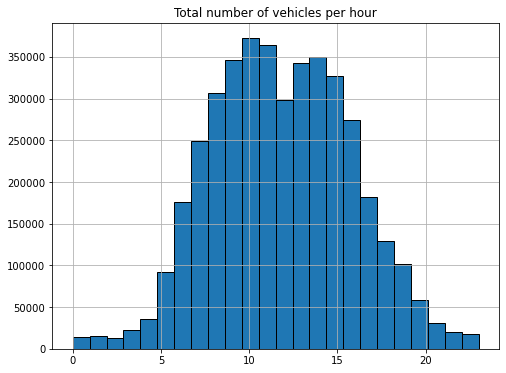

In [8]:
data.hour.hist(bins=24, edgecolor='black')
plt.title('Total number of vehicles per hour')
plt.show()

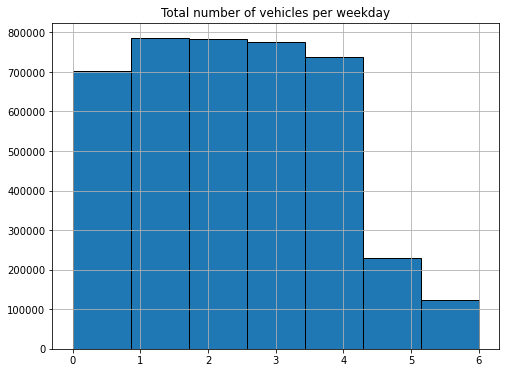

In [9]:
data.weekday.hist(bins=7, edgecolor='black')
plt.title('Total number of vehicles per weekday')
plt.show()

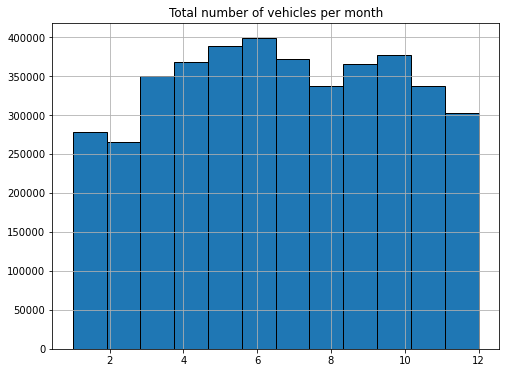

In [10]:
data.month.hist(bins=12, edgecolor='black')
plt.title('Total number of vehicles per month')
plt.show()

From our data exploration we know that there exist some missing data points, notably in 2013 and 2014, so we now inspect the data per year to check if the difference is due to missing data or due to seasonality.

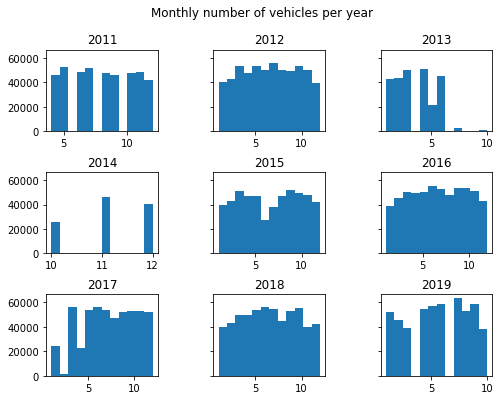

In [11]:
fig, axs = plt.subplots(3, 3, sharey=True)
years = data.year.unique()

for row in axs:
    for col in row:
        curr_year = years[0]
        years = years[1:]
        col.hist(data[data.year == curr_year].month, bins=12)
        col.set_title(curr_year)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle('Monthly number of vehicles per year')
plt.show()

Clearly there is some missing data so one cannot jump to conclusions concerning seasonality trends. Let's try to fit a linear regression model on the number of vehicles per week over the years:

                            OLS Regression Results                            
Dep. Variable:             n_vehicles   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     11.24
Date:                Thu, 23 Dec 2021   Prob (F-statistic):           0.000883
Time:                        14:45:08   Log-Likelihood:                -3454.7
No. Observations:                 374   AIC:                             6913.
Df Residuals:                     372   BIC:                             6921.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.028e+04    267.046     38.499      0.0

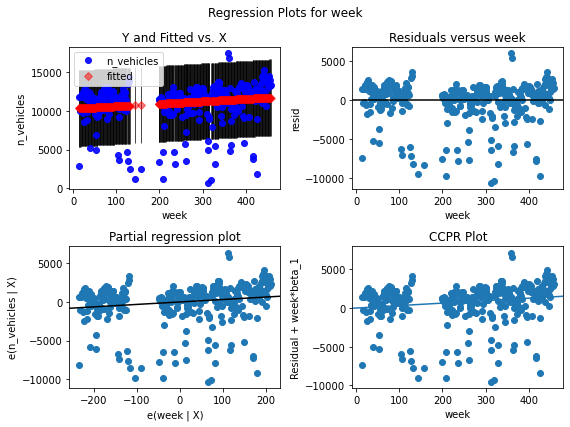

In [12]:
# We first form our datapoints: (week_i, number of vehicles)
weekly_vehicles = data.copy()[['year', 'crossTime']]
weekly_vehicles['week'] = weekly_vehicles.crossTime.map(lambda t: t.isocalendar()[1])
weekly_counts = weekly_vehicles.groupby(['year', 'week']).size().reset_index()
weekly_counts['week'] = weekly_counts.year.map(lambda y: y % 2011) * 52 + weekly_counts.week
weekly_counts = weekly_counts.drop('year', axis=1)
weekly_counts = weekly_counts.rename(columns={0:'n_vehicles'})
# Fit linear regression
model = smf.ols(formula='n_vehicles ~ 1 + week', data=weekly_counts)
res = model.fit()
print(res.summary())
fig = sm.graphics.plot_regress_exog(res, 'week')
fig.tight_layout(pad=1.0)

Text(0.5, 0, 'Week')

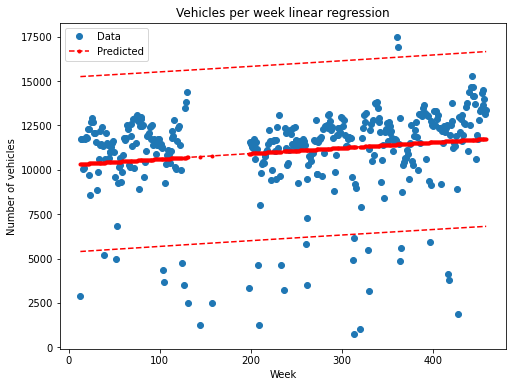

In [13]:
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

plt.plot(weekly_counts['week'], weekly_counts['n_vehicles'], "o", label="Data")
plt.plot(weekly_counts['week'], res.fittedvalues, "r--.", label="Predicted")
plt.plot(weekly_counts['week'], iv_u, "r--")
plt.plot(weekly_counts['week'], iv_l, "r--")
plt.legend(loc="best")
plt.title('Vehicles per week linear regression')
plt.ylabel('Number of vehicles')
plt.xlabel('Week')

Given the low amount of datapoints and noise from missing dates as seen with the monthly data, one can easily fall victim to observational bias. Let's have a look at weekday trends for each year as well just in case:

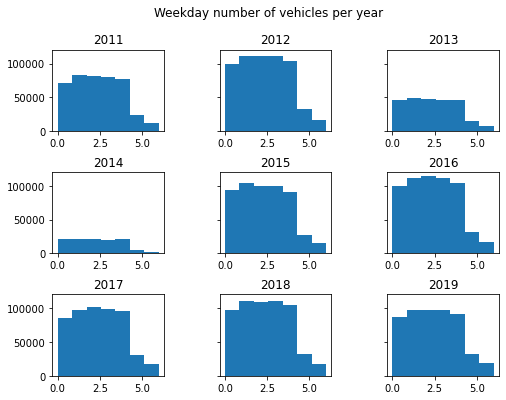

In [14]:
fig, axs = plt.subplots(3, 3, sharey=True)
years = data.year.unique()

for row in axs:
    for col in row:
        curr_year = years[0]
        years = years[1:]
        col.hist(data[data.year == curr_year].weekday, bins=7)
        col.set_title(curr_year)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle('Weekday number of vehicles per year')
plt.show()

Some observations to be made:
- There is a big drop on Saturday, and even more on Sunday.
- Weekdays are quite close together, especially Tuesday til Thursday
- Monday and Friday are sometimes identical to the other weekdays, but have a small but non-negligible so we will consider them separately just to be safe!

Therefore, we decide to make separate distributions for Monday, Tuesday-Thursday, Friday, Saturday, and Sunday (5 in total)

### Speed and weight
We would like to investigate possible relationships between speed, weight, and time
#### Speed

In [15]:
print(f'Minimum speed: {data.speed.min()}')
print(f'Maximum speed: {data.speed.max()}')

Minimum speed: 0
Maximum speed: 255


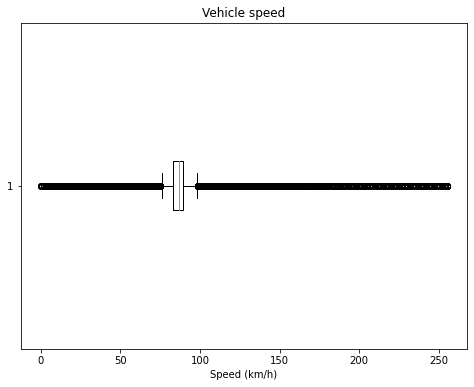

In [16]:
plt.boxplot(data.speed, vert=False, whis=[5, 95])
plt.xlabel('Speed (km/h)')
plt.title('Vehicle speed')
plt.show()

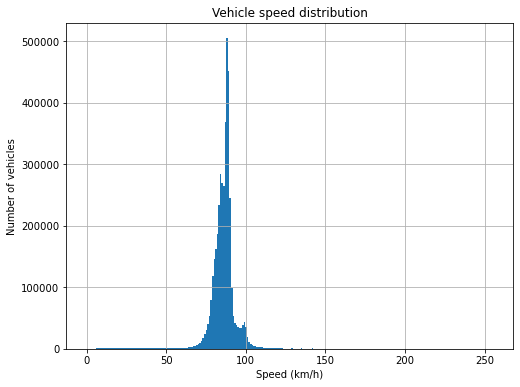

In [17]:
data.speed.hist(bins=256)
plt.title('Vehicle speed distribution')
plt.ylabel('Number of vehicles')
plt.xlabel('Speed (km/h)')
plt.show()

We observe that a large majority of vehicles are bunched together between 65 and 100 km/h, let's have a closer look:

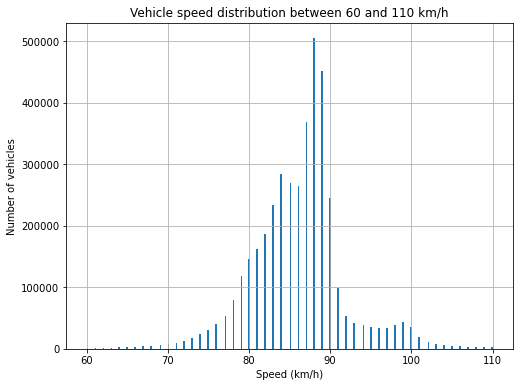

In [18]:
data.speed.hist(bins=256, range=[60, 110])
plt.title('Vehicle speed distribution between 60 and 110 km/h')
plt.ylabel('Number of vehicles')
plt.xlabel('Speed (km/h)')
plt.show()

#### Weight

In [19]:
print(f'Minimum weight: {data.weight.min()}')
print(f'Maximum weight: {data.weight.max()}')

Minimum weight: 3500
Maximum weight: 99940


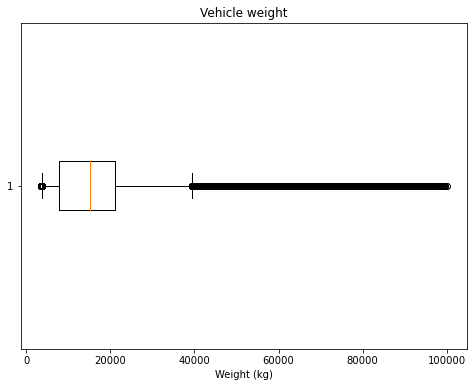

In [20]:
plt.boxplot(data.weight, vert=False, whis=[5, 95])
plt.xlabel('Weight (kg)')
plt.title('Vehicle weight')
plt.show()

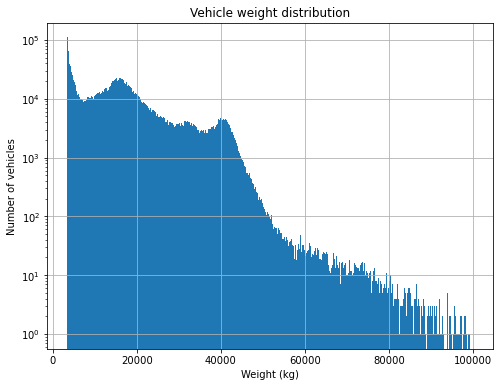

In [21]:
data.weight.hist(bins=1000, log=True)
plt.title('Vehicle weight distribution')
plt.ylabel('Number of vehicles')
plt.xlabel('Weight (kg)')
plt.show()

As seen above, vehicle weights is heavily left-tailed, with some rare exceptions weighing > 50 tons. We will now have a look at whether there is some seasonality for the weight measurements. 

In [22]:
month_weights = [data[data.month == i].weight for i in range(1, 13)]

In [23]:
month_sum = {}
month_mean = {}
month_median = {}
for i, mw in enumerate(month_weights):
    month_sum[i+1] = mw.sum()
    month_mean[i+1] = mw.mean()
    month_median[i+1] = mw.median()

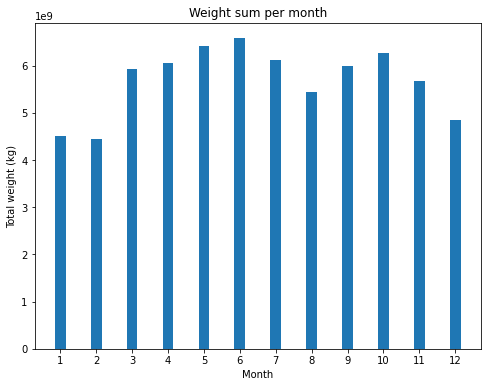

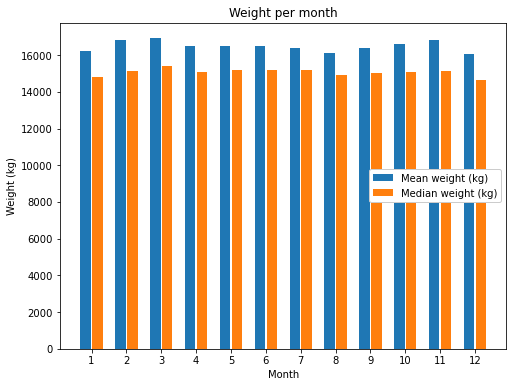

In [24]:
x_ = list(month_sum.keys()) # Month IDs
width = 0.3
# Total weight per month
plt.bar(x_, month_sum.values(), width)
plt.xticks(ticks=x_, labels=x_)
plt.title('Weight sum per month')
plt.ylabel('Total weight (kg)')
plt.xlabel('Month')
plt.show()

plt.bar(np.array(x_) - 0.17, month_mean.values(), width, label='Mean weight (kg)')
plt.bar(np.array(x_) + 0.17, month_median.values(), width, label='Median weight (kg)')
plt.xticks(ticks=x_, labels=x_)
plt.title('Weight per month')
plt.ylabel('Weight (kg)')
plt.xlabel('Month')
plt.legend(loc='right', framealpha=1)
plt.show()

The mean weight approximately varies between 16'000kg around 17'000kg for each month. We try to fit a linear regression for weight over hour of the day:

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                 1.798e+04
Date:                Thu, 23 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:45:23   Log-Likelihood:            -4.4264e+07
No. Observations:             4138411   AIC:                         8.853e+07
Df Residuals:                 4138409   BIC:                         8.853e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.853e+04     16.041   1155.324      0.0

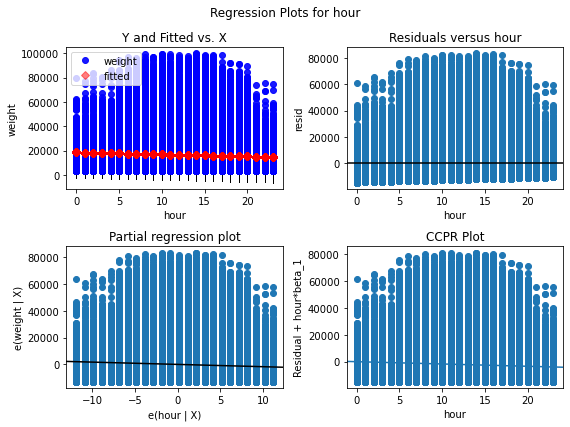

In [25]:
model = smf.ols(formula='weight ~ 1 + hour', data=data)
res = model.fit()
print(res.summary())
fig = sm.graphics.plot_regress_exog(res, 'hour')
fig.tight_layout(pad=1.0)

We also look at whether `n_vehicles` is correlated with `weight`:

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 5.288e+06
Date:                Thu, 23 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:50:35   Log-Likelihood:            -9.9854e+05
No. Observations:               75000   AIC:                         1.997e+06
Df Residuals:                   74998   BIC:                         1.997e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.883e+04    678.419    -71.979      0.0

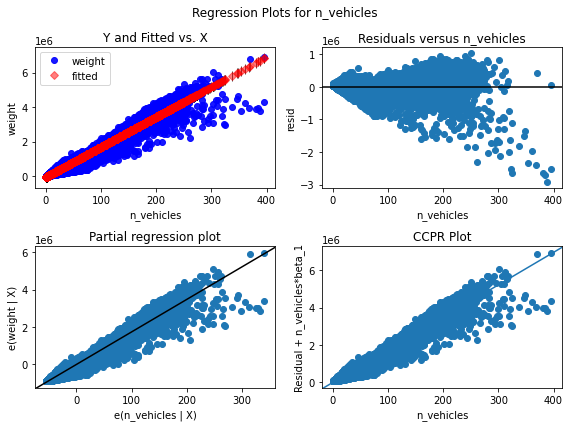

In [26]:
resampled = data.resample('1h', on='crossTime')
resampled_df = resampled.sum()
resampled_df['n_vehicles'] = resampled.size()

model = smf.ols(formula='weight ~ 1 + n_vehicles', data=resampled_df)
res = model.fit()
print(res.summary())
fig = sm.graphics.plot_regress_exog(res, 'n_vehicles')
fig.tight_layout(pad=1.0)

#### Are speed and weight correlated?
We must investigate whether speed and weight are related.

                            OLS Regression Results                            
Dep. Variable:                  speed   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                 4.034e+04
Date:                Thu, 23 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:50:43   Log-Likelihood:            -1.5065e+07
No. Observations:             4138411   AIC:                         3.013e+07
Df Residuals:                 4138409   BIC:                         3.013e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     87.2345      0.008   1.05e+04      0.0

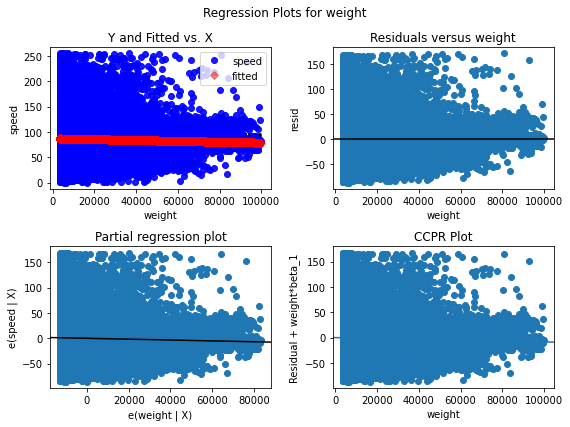

In [27]:
model = smf.ols(formula='speed ~ 1 + weight', data=data)
res = model.fit()
print(res.summary())
fig = sm.graphics.plot_regress_exog(res, 'weight')
fig.tight_layout(pad=1.0)

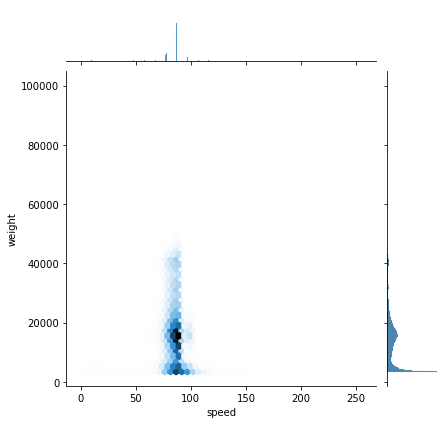

In [28]:
sns.jointplot(x='speed', y='weight', data=data, kind='hex')
plt.show()

It does not seem like there is a significant correlation between speed and weight of a vehicle, at least not at this scale. Let us look closer at smaller weight intervals instead:

0 < Weight <= 10000


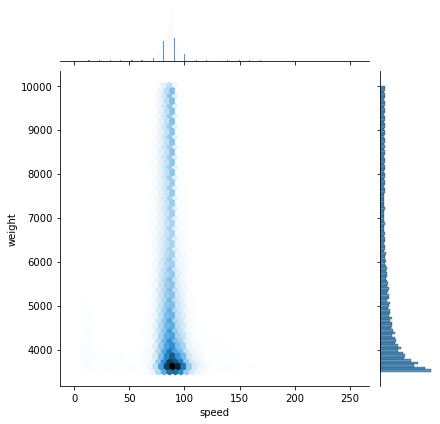

10000 < Weight <= 20000


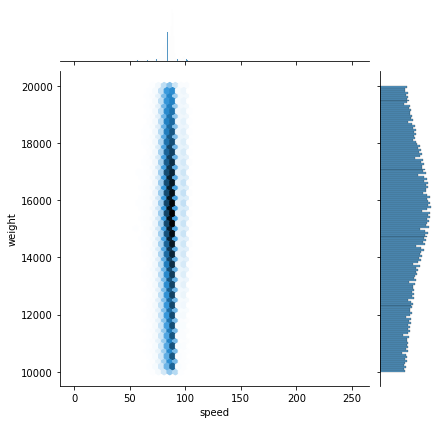

20000 < Weight <= 30000


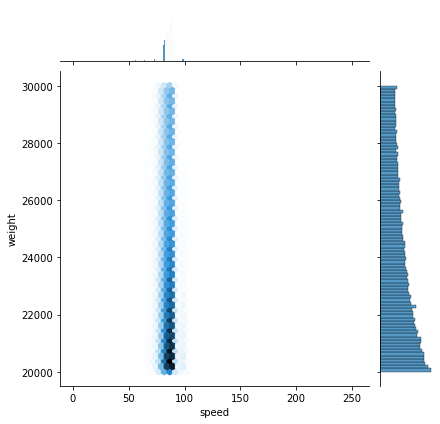

30000 < Weight <= 40000


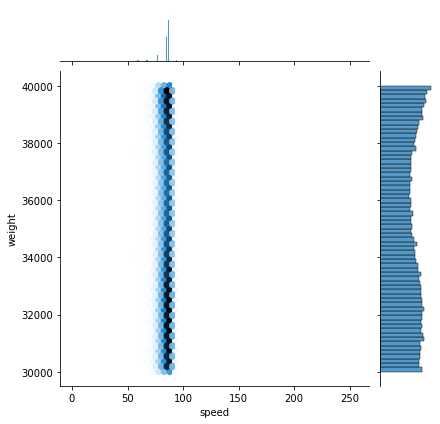

40000 < Weight <= 60000


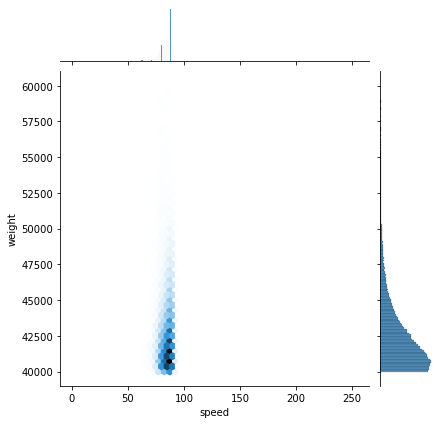

60000 < Weight <= 100000


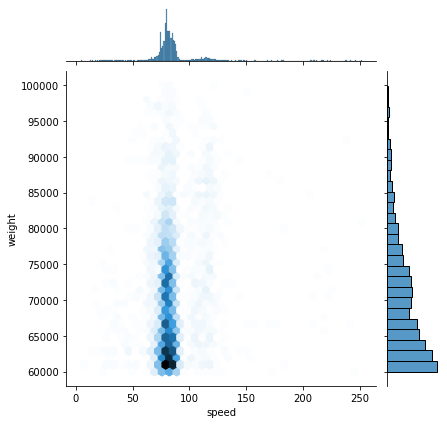

In [29]:
weight_cutoff = [0, 10000, 20000, 30000, 40000, 60000, 100000]
for i in range(6):
    lo, hi = weight_cutoff[0], weight_cutoff[1]
    print(f'{lo} < Weight <= {hi}')
    weight_cutoff = weight_cutoff[1:]
    sub_data = data[(data.weight > lo) & (data.weight <= hi)]
    sns.jointplot(x='speed', y='weight', data=sub_data, kind='hex')
    plt.show()

It seems like there are some slight differences in the distribution for certain weight ranges, so we should keep this in mind while generating a probability distribution for speed given a weight range.

## Discretization
Using our findings, we will construct probability distributions to construct samples as discrete events from our original predictions. 
### Crossing time
We decide to construct a distribution and assign a probability for every 5 minute interval of a day, and then take $n$ Poisson samples for that interval such that $n$ vehicles were assigned to that interval.
#### Poisson arrival times

In [30]:
rng = np.random.default_rng()
INTERVAL_SIZE = 5 * 60 # 5 minute intervals
def poisson_arrivals(n_vehicles):
    'Produce Poisson arrival times with rate=n_vehicles'
    rate = n_vehicles / INTERVAL_SIZE
    arrivals = []
    t = 0
    while (t <= INTERVAL_SIZE):
        r = rng.uniform()
        t = t - np.log(r) / rate
        if t > INTERVAL_SIZE:
            return arrivals
        else:
            arrivals.append(t)
    

#### Arrival interval probability distributions
We group our data into 5 minute intervals to generate a probability distribution of a vehicle to appear in this interval.

In [31]:
INTERVAL_WIDTH = 5 # 5 minute intervals
INTERVALS_PER_HOUR = int(60 / INTERVAL_WIDTH)
def assign_interval(minute):
    'Assigns the interval ID to a datapoint'
    for i in range(INTERVALS_PER_HOUR):
        if i*INTERVAL_WIDTH <= minute < (i+1)*INTERVAL_WIDTH:
            return i
    raise ValueError(f'ERROR minute={minute} too high. Expected 0 <= minute <= 59')

In [32]:
print(f'{INTERVALS_PER_HOUR} intervals per hour')

12 intervals per hour


In [33]:
day_id = {val: key for key, val in weekday_dict.items()}
DAY_HOURS = 24
DAY_INTERVALS = DAY_HOURS * 60 / INTERVAL_WIDTH # 24 hours x 60 minutes / 5 minute intervals

We can first assign the datapoints to their 5 minute intervals:

In [34]:
data['interval_id'] = data.minute.map(lambda m: assign_interval(m))

We will generate our probabilistic models now:

In [35]:
weekday_probs = {}

##### Monday

In [36]:
def day_data(day_name):
    'Get the data for a given day'
    return data[data.weekday == day_id[day_name]][['hour', 'interval_id']]

In [37]:
monday_data = day_data('Monday')
monday_data.sample(2)

,hour,interval_id
2504809,12,10
1357544,14,3


In [38]:
def day_probs(day_data):
    'Returns a dictionary of the probability assignments for the intervals of each hour'
    by_hour = day_data.groupby('hour')
    hourly_probs = {}
    for h in range(DAY_HOURS):
        hour_data = by_hour.get_group(h)['interval_id']
        n_arrivals = len(hour_data)
        probs = [count / n_arrivals for _, count in Counter(hour_data).items()]
        hourly_probs[h] = probs
    return hourly_probs

In [39]:
weekday_probs[day_id['Monday']] = day_probs(monday_data)

##### Tuesday-Thursday
As we discussed above, we consider these days together

In [40]:
select_days = (data.weekday == day_id['Tuesday']) | \
    (data.weekday == day_id['Wednesday']) | (data.weekday == day_id['Thursday'])
tue_thur = data[select_days][['hour', 'interval_id']]
tue_thur_probs = day_probs(tue_thur)
weekday_probs[day_id['Tuesday']] = tue_thur_probs
weekday_probs[day_id['Wednesday']] = tue_thur_probs
weekday_probs[day_id['Thursday']] = tue_thur_probs

##### Friday

In [41]:
friday_data = day_data('Friday')
weekday_probs[day_id['Friday']] = day_probs(friday_data)

##### Saturday

In [42]:
saturday_data = day_data('Saturday')
weekday_probs[day_id['Saturday']] = day_probs(saturday_data)

##### Sunday

In [43]:
sunday_data = day_data('Sunday')
weekday_probs[day_id['Sunday']] = day_probs(sunday_data)

##### Save probabilities

In [44]:
with open('weekday-probabilities.pickle', 'wb') as handle:
    pickle.dump(weekday_probs, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Generating predicted crossing time
We take as input a prediction with its wanted timeframe, weight, speed and number of vehicles. We take this input assign a set number of vehicles to their respective intervals, and then use a Poisson process to define their arrival times.

In [66]:
predict_df = pd.read_csv('../data/predictions.csv')
predict_df['crossTime'] = pd.to_datetime(predict_df.crossTime)
predict_df['n_vehicles'] = predict_df.n_vehicles.map(lambda n: 0 if n < 0 else n)
test_prediction = predict_df.iloc[1][['crossTime', 'n_vehicles']]
test_prediction

crossTime     2018-10-22 00:00:00
n_vehicles                   11.0
Name: 1, dtype: object

In [67]:
def predict_arrivals(prediction, probs_dict):
    'Predict arrival times'
    prediction_day, prediction_hour = \
        prediction['crossTime'].weekday(), prediction['crossTime'].hour
    n_vehicles = int(prediction['n_vehicles'])
    probs = probs_dict[prediction_day][prediction_hour]
    # Assign vehicles to their intervals
    assignments = np.random.choice(INTERVALS_PER_HOUR, p=probs, size=n_vehicles)
    # Initialize counter
    freq_iter = Counter({x:0 for x in np.arange(INTERVALS_PER_HOUR)})
    # Update with interval assignments
    freq_iter.update(assignments)
    # Interval time delta
    delta = datetime.timedelta(minutes=5)
    arrivals = []
    for id_, count in freq_iter.items():
        if count > 0:
            for time in poisson_arrivals(count):
                arrivals.append(id_*delta + datetime.timedelta(seconds=time))
    return prediction['crossTime'] + np.array(arrivals)

In [68]:
predict_arrivals(test_prediction, weekday_probs)

array([Timestamp('2018-10-22 00:15:58.862416'),
       Timestamp('2018-10-22 00:17:48.192259'),
       Timestamp('2018-10-22 00:24:01.679311'),
       Timestamp('2018-10-22 00:39:20.078363'),
       Timestamp('2018-10-22 00:40:39.940841'),
       Timestamp('2018-10-22 00:43:22.644583'),
       Timestamp('2018-10-22 00:55:48.707754'),
       Timestamp('2018-10-22 00:57:11.731740'),
       Timestamp('2018-10-22 00:57:49.680074')], dtype=object)

## From rate predictions to discrete arrival times
Here is how one would take all predictions to generate arrival times:

In [73]:
def arrival_times(predicted_rates, probs_dict):
    'Generate arrival times from predicted rates'
    arrivals = []
    for index, predicted in predicted_rates.iterrows():
        for arrival in predict_arrivals(predicted, probs_dict):
            arrivals.append(arrival)
    return arrivals

In [75]:
arrival_times = arrival_times(predict_df, weekday_probs)
# Sample 5 arrivals to show as example
np.random.choice(arrival_times, size=5, replace=False)

array([Timestamp('2018-12-29 16:41:47.867548'),
       Timestamp('2019-02-08 20:52:21.807409'),
       Timestamp('2019-01-16 09:15:59.846727'),
       Timestamp('2019-09-27 09:20:56.430098'),
       Timestamp('2019-06-26 17:08:02.623597')], dtype=object)

In [76]:
# Consecutive arrival times example
arrival_times[:5]

[Timestamp('2018-10-21 23:09:17.194231'),
 Timestamp('2018-10-21 23:09:25.202176'),
 Timestamp('2018-10-21 23:31:32.534573'),
 Timestamp('2018-10-21 23:33:15.712211'),
 Timestamp('2018-10-21 23:36:56.985680')]